# Assignment 4 - SMS Spam classification

> | Aldeesh P Rayan | 312319104010 |

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk

In [21]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [30]:
from keras.models import Model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [50]:
from sklearn.metrics import classification_report

## Load dataset: spam.csv

In [2]:
df = pd.read_csv("/home/fastbyte/Documents/random/ibm-assignment-4/spam.csv", encoding="latin-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<AxesSubplot: xlabel='v1', ylabel='count'>

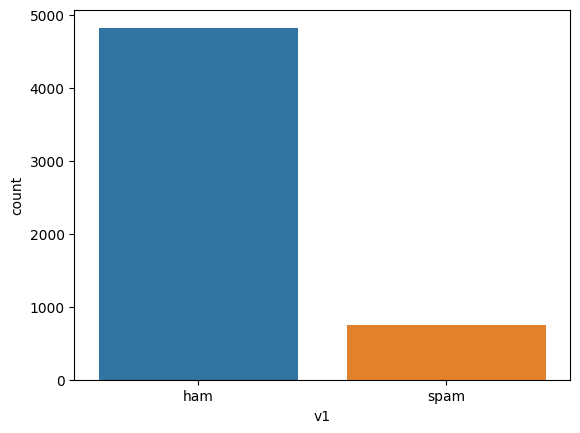

In [4]:
sns.countplot(data=df, x=df['v1'])

## Data preprocessing

In [6]:
text = df.loc[:, 'v2']
classification = df.loc[:, 'v1']

In [7]:
print(text)

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object


In [8]:
print(classification)

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: v1, Length: 5572, dtype: object


## Splitting dataset: test and train data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(text, classification, test_size=0.2, random_state=42)

In [14]:
# In case of `Lookup error` in NLTK - uncomment following line
# nltk.download('all')

text_length = []
for i in x_train :
    text_length.append(len(word_tokenize(i)))

In [15]:
print(max(text_length))

220


In [18]:
MAX_SEQUENCE_LENGTH = 38

token = Tokenizer()
token.fit_on_texts(x_train.values)

In [19]:
vocab_length = len(token.word_index)

In [20]:
x_train_sequences = token.texts_to_sequences(x_train.values)
x_test_sequences = token.texts_to_sequences(x_test.values)

In [22]:
x_train = pad_sequences(x_train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(x_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [27]:
y_train.values

array(['ham', 'spam', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

In [28]:
labelEncoder = LabelEncoder()

In [29]:
y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.fit_transform(y_test)
print(y_train)

[0 1 0 ... 0 0 0]


## Train the model - LSTM

In [31]:
def createModel(voclabLen, maxSeqLen):
    inputs = Input(name='inputs', shape=[maxSeqLen])
    layer = Embedding(voclabLen + 1, 50, input_length=maxSeqLen)(inputs)
    layer = LSTM(64)(layer) 
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    model.compile(loss='binary_crossentropy',optimizer=RMSprop(), metrics=['acc'])
    return model


In [33]:
model = createModel(vocab_length, MAX_SEQUENCE_LENGTH)

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 38)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 38, 50)            397750    
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [36]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size=128, 
    epochs=20, 
    validation_split=0.2
)

Epoch 1/20


2022-10-29 19:26:12.133630: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


28/28 [==============================] - 27s 158ms/step - loss: 0.3180 - acc: 0.8670 - val_loss: 0.1535 - val_acc: 0.9462
Epoch 2/20
28/28 [==============================] - 1s 32ms/step - loss: 0.0836 - acc: 0.9812 - val_loss: 0.0546 - val_acc: 0.9832
Epoch 3/20
28/28 [==============================] - 1s 33ms/step - loss: 0.0256 - acc: 0.9930 - val_loss: 0.0395 - val_acc: 0.9854
Epoch 4/20
28/28 [==============================] - 1s 35ms/step - loss: 0.0195 - acc: 0.9958 - val_loss: 0.0514 - val_acc: 0.9854
Epoch 5/20
28/28 [==============================] - 1s 31ms/step - loss: 0.0069 - acc: 0.9983 - val_loss: 0.0451 - val_acc: 0.9843
Epoch 6/20
28/28 [==============================] - 1s 34ms/step - loss: 0.0052 - acc: 0.9978 - val_loss: 0.0653 - val_acc: 0.9865
Epoch 7/20
28/28 [==============================] - 1s 34ms/step - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0649 - val_acc: 0.9787
Epoch 8/20
28/28 [==============================] - 1s 32ms/step - loss: 7.3985e-04 - acc: 1

## Plotting Loss and Accuracy of model

In [37]:
hist = history.history
hist.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

### Loss history

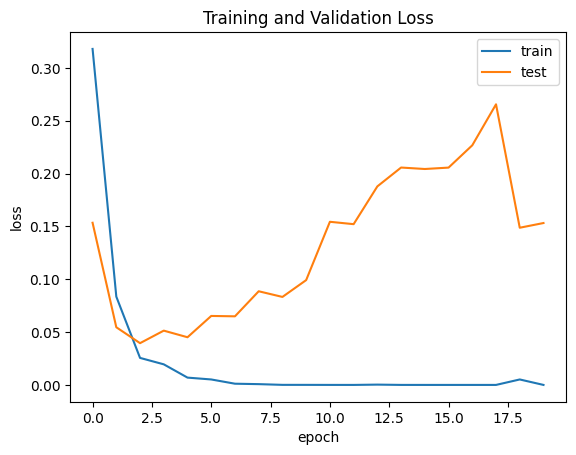

In [39]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Accuracy history

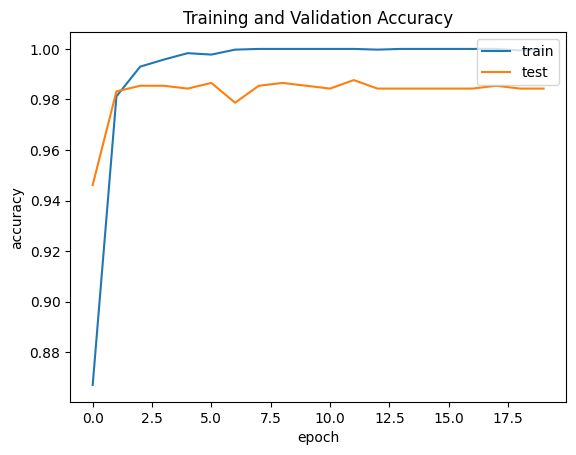

In [40]:
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Save model

In [41]:
model.save('/home/fastbyte/Documents/random/ibm-assignment-4/Assignment_4_final_model.h5')

## Testing model -> Perform predictions

### Load saved model

In [42]:
savedModel = load_model('/home/fastbyte/Documents/random/ibm-assignment-4/Assignment_4_final_model.h5')

### Evaluate with test data

In [43]:
testLoss, testAcc = savedModel.evaluate(x_test, y_test)

35/35 [==============================] - 2s 16ms/step - loss: 0.1858 - acc: 0.9865


In [44]:
print(f"Test results\n{testAcc=}\n{testLoss=}")

Test results
testAcc=0.9865471124649048
testLoss=0.18577957153320312


In [46]:
y_pred_prob = savedModel.predict(x_test)

35/35 [==============================] - 2s 7ms/step


In [47]:
print(np.round(y_pred_prob, 3))

[[0.197]
 [0.   ]
 [0.99 ]
 ...
 [0.   ]
 [0.   ]
 [1.   ]]


In [48]:
y_pred = y_pred_prob > 0.5
y_pred

array([[False],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [ True]])

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.90      0.95       150

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115

